In [60]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import plotly.express as px
import plotly.graph_objects as go

import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
# Import library untuk Clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [61]:
df = pd.read_csv('/content/drive/MyDrive/retail_customer_reviews/Sample - Superstore.csv',encoding = 'ISO-8859-1')

In [62]:
df[['Order Date','Ship Date']] = df[['Order Date','Ship Date']].astype('datetime64')
df[['Segment','Category','Sub-Category','Ship Mode']] = df[['Segment','Category','Sub-Category','Ship Mode']].astype('category')

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   int64         
 1   Order ID       9994 non-null   object        
 2   Order Date     9994 non-null   datetime64[ns]
 3   Ship Date      9994 non-null   datetime64[ns]
 4   Ship Mode      9994 non-null   category      
 5   Customer ID    9994 non-null   object        
 6   Customer Name  9994 non-null   object        
 7   Segment        9994 non-null   category      
 8   Country        9994 non-null   object        
 9   City           9994 non-null   object        
 10  State          9994 non-null   object        
 11  Postal Code    9994 non-null   int64         
 12  Region         9994 non-null   object        
 13  Product ID     9994 non-null   object        
 14  Category       9994 non-null   category      
 15  Sub-Category   9994 n

``` At this stage, we have to define a last day for the time range. This is called snapshot day. We can gather this snapshot date with the .max() function in Python and append one day to that date. But first, we need to process the InvoiceDate column. The observations in the column are including the hour and minute. We’re operating in a year of range, that means hour and minute datas are meaningless for us. We’re going to exclude them and continue with taking the last day of the InvoiceDate column. ```

In [64]:
df = df[df["Profit"]>=0]

R (Recency) : Jumlah hari sejak pembelian terakhir

F (Frequency) : Jumlah ‘proses transaksi

M (Monetary) : Jumlah total transaksi (kontribusi pendapatan)

In [65]:
snapshot = df['Order Date'].max()
snapshot

Timestamp('2017-12-30 00:00:00')

In [66]:
customer_group = df.groupby("Customer ID") 
recency = (snapshot - customer_group["Order Date"].max()) 
frequency = customer_group["Order ID"].nunique() 
monetary = customer_group["Profit"].sum()
rfm = rfm = pd.DataFrame() 
rfm["Recency"] = recency.dt.days 
rfm["Frequency"] = frequency
rfm["Monetary"] = monetary
rfm

,Recency,Frequency,Monetary
Customer ID,,,
AA-10315,184,5,423.1319
AA-10375,19,9,277.3824
AA-10480,259,4,435.8274
AA-10645,55,6,877.8388
AB-10015,415,2,131.8713
...,...,...,...
XP-21865,43,11,648.5222
YC-21895,4,5,1305.6290
YS-21880,9,7,1816.5039


In [67]:
customer_group = df.groupby("Customer ID") # grouping the customer id's to see every single customer's activity on r, f , m
recency = (snapshot - customer_group["Order Date"].max()) # the last day of grouped customer's transaction is captured with .max()
frequency = customer_group["Order ID"].nunique() # how many times the customer made transactions?
monetary = customer_group["Profit"].sum()
rfm = rfm = pd.DataFrame() # opened a new rfm dataframe
rfm["Recency"] = recency.dt.days # FORMAT CHANGE: timedelta64 to integer
rfm["Frequency"] = frequency
rfm["Monetary"] = monetary
rfm

,Recency,Frequency,Monetary
Customer ID,,,
AA-10315,184,5,423.1319
AA-10375,19,9,277.3824
AA-10480,259,4,435.8274
AA-10645,55,6,877.8388
AB-10015,415,2,131.8713
...,...,...,...
XP-21865,43,11,648.5222
YC-21895,4,5,1305.6290
YS-21880,9,7,1816.5039


Langkah selanjutnya akan dilakukan analisis terhadap outlier menggunakan boxplot, dengan langkah sebagai berikut:

Text(0.5, 0, 'Attributes')

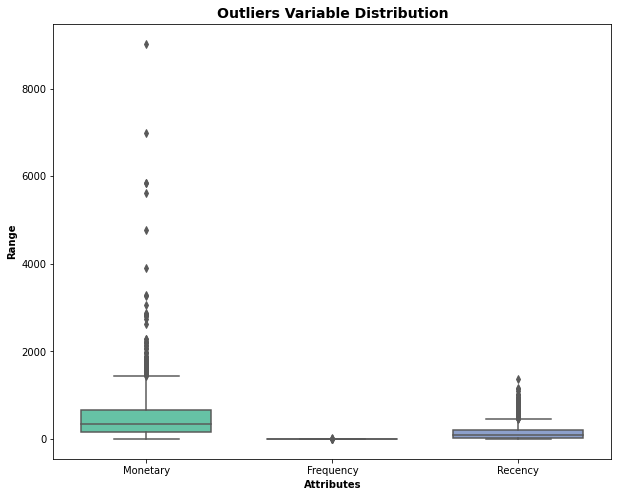

In [68]:
#Analysis outlier
attributes = ['Monetary','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

Nilai Outlier merupakan nilai data yang letaknya lebih dari 1.5 x panjang kotak (IQR), dengan formulasi detail sebagai berikut:




Untuk langkah selanjutnya, akan dilakukan penghapusan terhadap outliers yang ada, dengan langkah sebagai berikut:

In [69]:
# Removing (statistical) outliers for Monetary
Q1 = rfm.Monetary.quantile(0.05)
Q3 = rfm.Monetary.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Monetary >= Q1 - 1.5*IQR) & (rfm.Monetary <= Q3 + 1.5*IQR)]
# Removing (statistical) outliers for Recency
Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]
# Removing (statistical) outliers for Frequency
Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

Tahap selanjutnya yaitu, akan dilakukan rescaling terhadap atribut-atribut yang ada. Rescaling atribut merupakan salah satu tahap yang penting agar masing-masing atribut memiliki skala yang sebanding. Pada case ini, akan digunakan Standardisation Scaling terhadap masing-masing atribut, dengan langkah sebagai berikut:

In [70]:
# Rescaling Atribute
rfm_df = rfm[['Monetary', 'Frequency', 'Recency']]
# Instantiate
scaler = StandardScaler()
# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(786, 3)

In [71]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()

,Amount,Frequency,Recency
0,-0.167094,-0.249612,0.071235
1,-0.433559,1.456430,-0.707205
2,-0.143883,-0.676122,0.425072
3,0.664219,0.176899,-0.537363
4,-0.699588,-1.529143,1.161052


Step 4 : Model Building
Langkah selanjutnya, yaitu menentukan nilai K. Pada langkah ini, akan dikonfigurasi dan ditentukan nilai inisiasi k (n_clusters) sebesar 4 cluster.

In [95]:
kmeans = KMeans(n_clusters=2, max_iter=50)
kmeans.fit(rfm_df_scaled)


KMeans(max_iter=50, n_clusters=2)

Karena kami berhasil menyiapkan tabel RFM, kami dapat pindah ke bagian yang menarik; klasifikasi pelanggan dengan sklearn! Hanya pengingat singkat untuk tabel: nilai 0 tidak mengganggu kami karena pelanggan yang relevan dapat memiliki pengembalian dana, atau menggunakan beberapa promosi. Dengan cara ini nilai tambah moneter menjadi nol. Untuk membangun model KMeans kita, kita perlu memutuskan jumlah segmen dengan metode elbow, maka kita dapat membangun model menggunakan jumlah cluster/segmen tersebut. Setelah itu, kita akan memanusiakan model tanpa pengawasan.

Selanjutnya, akan dicari jumlah optimal dari cluster (k) dengan menggunakan metode Elbow Curve.

Elbow Curve, merupakan salah satu metode yang bisa digunakan untuk menemukan jumlah optimal dari cluster (k), yang langkah-langkah pengerjaan adalah sebagai berikut:

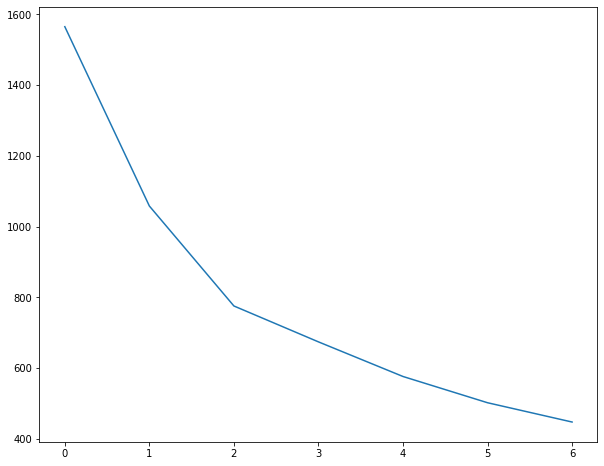

In [96]:
# Elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6,7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)

Pada elbow curve method, lokasi ‘tikungan’ yang terbentuk di plot, pada umumnya dianggap sebagai indikator jumlah cluster yang tepat [2].
Akan tetapi nilai k ‘optimal’ yang diperoleh dari metode elbow curve, sering kali bersifat “ambigu” atau belum pasti akan menghasilkan jumlah cluster (k) yang optimal.

Oleh karena itu, langkah selanjutnya akan digunakan Silhouette Analysis guna mencari nilai k optimal.

Silhouette Analysis
Secara umum, algoritma dari Silhouette analysis yaitu mengukur seberapa dekat (baik) setiap titik pada sebuah cluster dengan titik-titik data lain di clusternya. Semakin tinggi nilai rata-rata dari silhouette, menunjukkan suatu peng-cluster-an yang baik. Secara matematis, dapat dirumuskan sebagai berikut:


dengan :

p : jarak rata-rata, ke titik-titik di cluster terdekat


q : jarak rata-rata intra cluster ke semua titik di clusternya sendiri

Nilai dari Sillhouette ada diantara -1 sampai dengan 1. Jika nilainya mendekati angka 1, maka titik data akan sangat mirip dengan titik data lainnya di cluster yang sama. Jika mendekati -1 maka titik data tersebut tidak mirip dengan titik data di klusternya.

In [86]:
# Silhouette Analysis
range_n_clusters = [2, 3, 4, 5, 6,7 ,8]
for num_clusters in range_n_clusters:
    
    # Initialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    cluster_labels = kmeans.labels_
    
    # Silhouette Score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.3200322681047963
For n_clusters=3, the silhouette score is 0.41224468156030974
For n_clusters=4, the silhouette score is 0.354142313956662
For n_clusters=5, the silhouette score is 0.3057702671257925
For n_clusters=6, the silhouette score is 0.3337265366101927
For n_clusters=7, the silhouette score is 0.33697765269765784
For n_clusters=8, the silhouette score is 0.31341131600277417


Berdasarkan output tersebut, dapat disimpulkan bahwa untuk n_clusters=3 menghasilkan nilai silhouette yang tinggi.

In [87]:
# Final model with k=5
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=3)

Langkah selanjutnya yaitu menetapkan label cluster untuk setiap titik data sebagai berikut:

In [88]:
# Assign the label
rfm['Cluster_Id'] = kmeans.labels_
rfm.head()

,Recency,Frequency,Monetary,Cluster_Id
Customer ID,,,,
AA-10315,184,5,423.1319,0
AA-10375,19,9,277.3824,0
AA-10480,259,4,435.8274,0
AA-10645,55,6,877.8388,0
AB-10015,415,2,131.8713,1


In [89]:
rfm[(rfm['Cluster_Id'] ==4)| (rfm['Cluster_Id']==3)]

,Recency,Frequency,Monetary,Cluster_Id
Customer ID,,,,


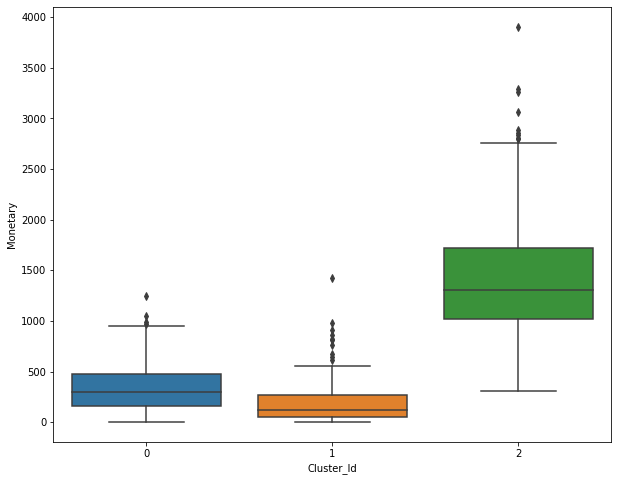

In [90]:
# Boxplot untuk memvisualisasikan Cluster Id dan Monetary
sns.boxplot(x='Cluster_Id', y='Monetary', data=rfm)

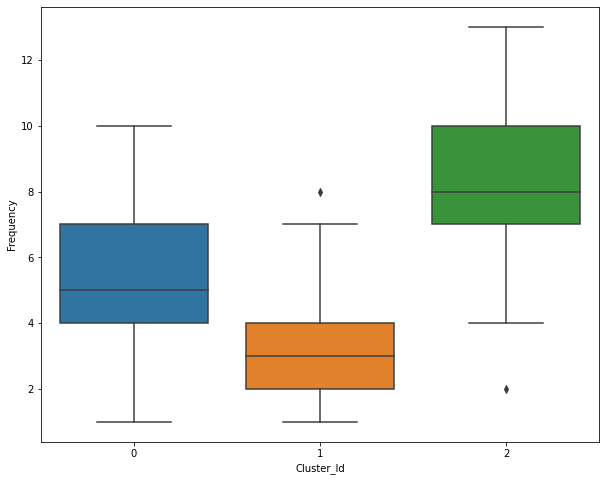

In [91]:
# Boxplot untuk memvisualisasikan Cluster Id vs Frequency
sns.boxplot(x='Cluster_Id', y='Frequency', data=rfm)

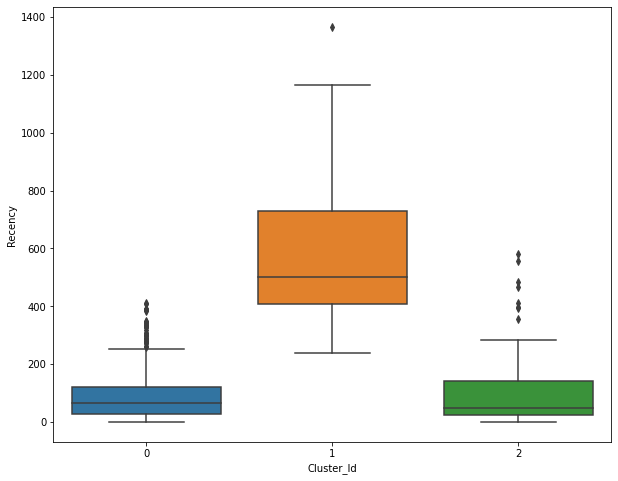

In [92]:
# Boxplot untuk memvisualisasikan Cluster Id vs Recency
sns.boxplot(x='Cluster_Id', y='Recency', data=rfm)

In [93]:
rfm.groupby("Cluster_Id").mean()

,Recency,Frequency,Monetary
Cluster_Id,,,
0,93.089695,5.469466,344.012177
1,572.487805,3.195122,208.074631
2,97.561151,8.136691,1428.513752


In [94]:
Humanization = {2:"Gold",0:"Silver",1:"Bronze"}
rfm['Cluster_Id'].replace(Humanization,inplace = True)
rfm.head(6)

,Recency,Frequency,Monetary,Cluster_Id
Customer ID,,,,
AA-10315,184,5,423.1319,Silver
AA-10375,19,9,277.3824,Silver
AA-10480,259,4,435.8274,Silver
AA-10645,55,6,877.8388,Silver
AB-10015,415,2,131.8713,Bronze
AB-10060,54,8,2127.6433,Gold


Step 5 : Final Analysis
Berdasarkan langkah-langkah pengerjaan yang telah dilakukan, dapat disimpulkan bahwa :

Cluster Gold 